In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 设置中文显示
plt.rcParams['font.family'] = ['Microsoft YaHei'] 
plt.rcParams['axes.unicode_minus'] = False

# 读取数据
df = pd.read_excel('每日行情/百邦科技(300736.SZ)_每日行情数据统计.xlsx', skiprows=2, nrows=1691)

# 数据清洗
def clean_stock_data(df):
    # 检查所有数据是否有缺失值
    missing_values = df.isnull().sum()
    print("各列缺失值数量：")
    print(missing_values)
    
    # 检查收盘价是否在最高价和最低价之间
    invalid_prices = ~((df['收盘价(元)'] >= df['最低价(元)']) & 
                      (df['收盘价(元)'] <= df['最高价(元)']))
    
    # 对无效价格进行修正(使用前一天或后一天的收盘价)
    if invalid_prices.any():
        df.loc[invalid_prices, '收盘价(元)'] = df['收盘价(元)'].shift(1)
        df.loc[invalid_prices, '收盘价(元)'].fillna(df['收盘价(元)'].shift(-1))
    
    return df

# 清洗数据
df_cleaned = clean_stock_data(df)

各列缺失值数量：
交易日期      0
开盘价(元)    0
最高价(元)    0
最低价(元)    0
收盘价(元)    0
成交量(股)    0
成交额(元)    0
dtype: int64


c:\Users\93516\anaconda3\envs\pytorch\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
def prepare_data(df):
    # 将日期设为索引
    df['交易日期'] = pd.to_datetime(df['交易日期'])
    df.set_index('交易日期', inplace=True)
    
    # 获取收盘价序列
    prices = df['收盘价(元)'].values.reshape(-1, 1)
    
    # 标准化
    scaler = StandardScaler()
    prices_scaled = scaler.fit_transform(prices)
    
    # 数据集划分 (7:2:1)
    n = len(prices_scaled)
    train_size = int(n * 0.7)
    val_size = int(n * 0.2)
    
    train_data = prices_scaled[:train_size]
    val_data = prices_scaled[train_size:train_size+val_size]
    test_data = prices_scaled[train_size+val_size:]
    
    return train_data, val_data, test_data, scaler

# 准备数据
train_data, val_data, test_data, scaler = prepare_data(df_cleaned)

In [ ]:
# def prepare_data(df):
#     # 将日期设为索引
#     df['交易日期'] = pd.to_datetime(df['交易日期'])
#     df.set_index('交易日期', inplace=True)
    
#     # 获取收盘价序列并标准化
#     prices = df['收盘价(元)'].values.reshape(-1, 1)
#     scaler = StandardScaler()
#     prices_scaled = scaler.fit_transform(prices)
    
#     # 实现前向链接法划分数据集
#     n = len(prices_scaled)
#     fold_size = n // 5  # 将数据等分成5份
    
#     # 最后两份数据分别作为最终验证集和测试集
#     final_val_data = prices_scaled[3*fold_size:4*fold_size]
#     final_test_data = prices_scaled[4*fold_size:]
    
#     # 前三份数据用于前向链接训练
#     forward_folds = []
#     for i in range(3):
#         # 第i轮训练的数据划分
#         train_end = (i + 1) * fold_size
#         val_end = (i + 2) * fold_size
#         test_end = (i + 3) * fold_size
        
#         train_data = prices_scaled[:train_end]
#         val_data = prices_scaled[train_end:val_end]
#         test_data = prices_scaled[val_end:test_end]
        
#         forward_folds.append({
#             'train': train_data,
#             'val': val_data,
#             'test': test_data
#         })
    
#     return {
#         'forward_folds': forward_folds,  # 前向链接训练的三轮数据
#         'final_val': final_val_data,     # 最终验证集
#         'final_test': final_test_data,   # 最终测试集
#         'scaler': scaler
#     }

# # 准备数据
# data = prepare_data(df_cleaned)

# # 打印每一轮训练的数据集大小
# for i, fold in enumerate(data['forward_folds']):
#     print(f"\n第{i+1}轮训练:")
#     print(f"训练集大小: {len(fold['train'])}")
#     print(f"验证集大小: {len(fold['val'])}")
#     print(f"测试集大小: {len(fold['test'])}")

# print("\n最终数据集:")
# print(f"最终验证集大小: {len(data['final_val'])}")
# print(f"最终测试集大小: {len(data['final_test'])}")

In [5]:
def calculate_metrics(y_true, y_pred):
    # RAE (Relative Absolute Error)
    rae = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true - np.mean(y_true)))
    
    # RSE (Relative Squared Error)
    rse = np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
    
    return rae, rse

In [7]:
def train_arima(train_data, val_data):
    best_aic = float('inf')
    best_order = None
    
    # 网格搜索最佳参数
    for p in range(0, 5):
        for d in range(0, 2):
            for q in range(0, 5):
                try:
                    model = ARIMA(train_data, order=(p, d, q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                except:
                    continue
    
    # 使用最佳参数训练模型
    final_model = ARIMA(train_data, order=best_order)
    final_results = final_model.fit()
    
    # 预测验证集
    forecast = final_results.forecast(steps=len(val_data))
    
    return final_results, forecast, best_order

# 训练模型
model, val_pred, best_order = train_arima(train_data.flatten(), val_data.flatten())

c:\Users\93516\anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\93516\anaconda3\envs\pytorch\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\93516\anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\93516\anaconda3\envs\pytorch\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\9351

In [ ]:
# def train_evaluate_arima(data):
#     all_metrics = []
#     best_order = None
#     best_metrics = {'rae': float('inf'), 'rse': float('inf')}
    
#     # 前向链接训练
#     for i, fold in enumerate(data['forward_folds']):
#         print(f"\n训练第{i+1}轮模型...")
        
#         # 网格搜索最佳参数
#         best_fold_metrics = {'rae': float('inf'), 'rse': float('inf')}
        
#         for p in range(0, 3):
#             for d in range(0, 2):
#                 for q in range(0, 3):
#                     try:
#                         # 训练模型
#                         model = ARIMA(fold['train'].flatten(), order=(p, d, q))
#                         results = model.fit()
                        
#                         # 预测测试集
#                         forecast = results.forecast(steps=len(fold['test']))
                        
#                         # 计算评估指标
#                         rae, rse = calculate_metrics(fold['test'].flatten(), forecast)
                        
#                         # 更新最佳参数
#                         if (rae + rse) < (best_fold_metrics['rae'] + best_fold_metrics['rse']):
#                             best_fold_metrics = {'rae': rae, 'rse': rse}
#                             if i == 0:  # 只在第一轮保存最佳参数
#                                 best_order = (p, d, q)
#                     except:
#                         continue
        
#         all_metrics.append(best_fold_metrics)
    
#     # 计算平均评估指标
#     avg_rae = np.mean([m['rae'] for m in all_metrics])
#     avg_rse = np.mean([m['rse'] for m in all_metrics])
    
#     print("\n前向链接训练结果:")
#     print(f"平均RAE: {avg_rae:.4f}")
#     print(f"平均RSE: {avg_rse:.4f}")
#     print(f"最佳ARIMA参数: {best_order}")
    
#     # 使用最佳参数训练最终模型
#     final_train_data = np.concatenate([fold['train'] for fold in data['forward_folds']])
#     final_model = ARIMA(final_train_data.flatten(), order=best_order)
#     final_results = final_model.fit()
    
#     # 预测最终测试集
#     final_forecast = final_results.forecast(steps=len(data['final_test']))
#     final_rae, final_rse = calculate_metrics(data['final_test'].flatten(), final_forecast)
    
#     print("\n最终测试集结果:")
#     print(f"RAE: {final_rae:.4f}")
#     print(f"RSE: {final_rse:.4f}")
    
#     return final_results, best_order

# # 训练和评估模型
# final_model, best_order = train_evaluate_arima(data)

Best ARIMA order: (2, 1, 4)
Validation RAE: 1.0323
Validation RSE: 1.0208


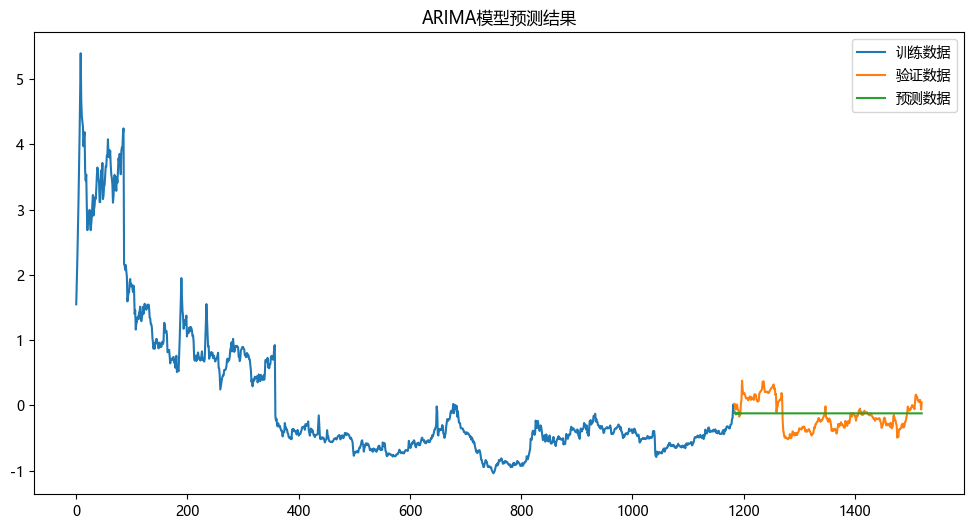

In [8]:
def plot_results(train_data, val_data, val_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), train_data, label='训练数据')
    plt.plot(range(len(train_data), len(train_data) + len(val_data)), 
             val_data, label='验证数据')
    plt.plot(range(len(train_data), len(train_data) + len(val_data)), 
             val_pred, label='预测数据')
    plt.title('ARIMA模型预测结果')
    plt.legend()
    plt.show()

# 计算验证集上的评估指标
rae_val, rse_val = calculate_metrics(val_data.flatten(), val_pred)

print(f'Best ARIMA order: {best_order}')
print(f'Validation RAE: {rae_val:.4f}')
print(f'Validation RSE: {rse_val:.4f}')

# 绘制结果
plot_results(train_data.flatten(), val_data.flatten(), val_pred)